In [1]:
import cv2
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn import mixture
from sklearn.decomposition import PCA
import time
import sys
import scipy.ndimage
import scipy.ndimage as ndimage
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import normalize
from matplotlib.colors import LogNorm
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
#%matplotlib notebook
import seaborn as sns
%config InlineBackend.figure_format = 'retina'
from pylab import rcParams
rcParams['figure.figsize'] = (9, 6)
import warnings
warnings.filterwarnings(action='once')

In [2]:
def classify1(features, MX, stop_imm = True, tp = 'full'):
    newdata = features
    n_components = np.arange(1, MX + 1)
    BIC = np.zeros(n_components.shape)
    lowest_bic = np.infty
    best_gmm = None

    for i, n in enumerate(n_components):        
        gmm = GaussianMixture(n_components=n, covariance_type=tp, random_state=0)
        gmm.fit(newdata)
        BIC[i] = gmm.bic(newdata)
        dbic = np.abs(BIC[i] - lowest_bic) / np.abs(BIC[i])
        print(n, BIC[i], dbic)
        if BIC[i] < lowest_bic:
        #if dbic >= 1e-3:        
            lowest_bic = BIC[i]
            best_gmm = gmm
        elif stop_imm:
            break

    best_gmm = GaussianMixture(n_components=best_gmm.n_components, covariance_type=tp, random_state=0)
    best_gmm.fit(features)

    print(best_gmm.n_components)
    plt.figure()
    plt.plot(BIC)
    plt.show()
    return best_gmm

def classify4(features):
    parameters = {
        'n_components' : np.arange(1, 15)
    }
    clf = GridSearchCV(GaussianMixture(covariance_type='full'), parameters, cv=5, n_jobs=-1)
    clf.fit(features)
    print("n_components",clf.best_estimator_.n_components)
    return clf.best_estimator_

def plot_array(arr):
    ny, nx = arr.shape
    xv, yv = np.meshgrid(np.linspace(0, nx, nx), np.linspace(0, ny, ny))
    fig = plt.figure()
    ax = Axes3D(fig)
    ax.plot_surface(xv,yv,arr)
    plt.show()

In [3]:
df = pd.read_csv("data_reception_short_train.csv")
df.drop([df.columns[0], "Rf"], inplace=True, axis=1)
scaler = MinMaxScaler((0, 10))
df2 = df.drop([df.columns[0], df.columns[1]], axis=1)
df2 = pd.DataFrame(scaler.fit_transform(df2), columns=df.columns[2:])


#df2 = df.drop([df.columns[0], df.columns[1]], axis=1)
#from sklearn.decomposition import PCA
#pca = PCA(0.99, whiten=True)
#df2 = pd.DataFrame(pca.fit_transform(df2))

#df2 = df.drop([df.columns[0], df.columns[1]], axis=1)
#df2 = pd.DataFrame(df2, columns=df.columns[2:])


display(df2.describe())
display(df2.head(5))

,x,y,w,h,mx,my
count,35872.000000,35872.000000,35872.000000,35872.000000,35872.000000,35872.000000
mean,7.977411,4.260938,2.146096,2.467953,4.562727,3.035709
std,1.956844,1.590913,1.500537,2.071122,0.227528,0.127263
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7.517007,3.684211,1.355932,1.219512,4.565217,3.035714
50%,8.571429,3.973684,1.779661,1.544715,4.565217,3.035714
75%,9.353741,4.473684,2.372881,3.170732,4.565217,3.035714
max,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000


,x,y,w,h,mx,my
0,9.438776,4.447368,1.440678,1.300813,4.565217,3.035714
1,9.438776,4.447368,1.440678,1.300813,4.565217,3.035714
2,9.438776,4.447368,1.440678,1.300813,4.565217,3.035714
3,9.438776,4.447368,1.440678,1.300813,4.565217,3.035714
4,9.914966,3.947368,0.423729,1.707317,4.565217,3.035714


In [4]:
#bgmm = classify1(df2, 19, True)
bgmm = classify4(df2)

n_components 14


In [5]:
def extend_set(df):
    df_tmp = df[["time", "frame"]].groupby(['time', 'frame']).agg('count')
    df_tmp.reset_index(inplace=True)

    first_time = df_tmp.iloc[0]["time"] 
    first_frame = df_tmp.iloc[0]["frame"]

    last_time = df_tmp.iloc[len(df_tmp) - 1]["time"]
    last_frame = df_tmp.iloc[len(df_tmp) - 1]["frame"]

    dt_time = df_tmp.iloc[len(df_tmp) - 1]["time"] - df_tmp.iloc[len(df_tmp) - 2]["time"]
    dt_frame = df_tmp.iloc[len(df_tmp) - 1]["frame"] - df_tmp.iloc[len(df_tmp) - 2]["frame"]

    df_app = df.apply(lambda x: [x['time'] - first_time + last_time + dt_time, x['frame'] - first_frame + last_frame + dt_frame] + list(x[2:]), axis=1)
    df_app = df.append(df_app)
    df_app.reset_index(inplace=True, drop=True)
    return df_app
#df = extend_set(df)
#df = extend_set(df)
#df = extend_set(df)

#df2 = df.drop([df.columns[0], df.columns[1]], axis=1)
#df2 = pd.DataFrame(scaler.transform(df2), columns=df.columns[2:])

In [6]:
df3 = pd.DataFrame(bgmm.predict_proba(df2))
df3["time"] = df["time"]
df3["frame"] = df["frame"]
df3 = df3.groupby(['time', 'frame']).agg('max')
df3.reset_index(inplace=True)

#display(df3.head(11))

#df3 = df3.apply(lambda x: [x['time'], x['frame']] + list(x[2:] / x[2:].sum()), axis=1)
#df3_test = df3_test.apply(lambda x: [x['time'], x['frame']] + list(x[2:] / x[2:].sum()), axis=1)

display(df3.head(11))

#arr = df3_test.drop(["frame", "time"], axis=1)
#display(np.array(arr))
#display(np.array(arr) / np.linalg.norm(arr, axis=1))

PN = []

last_t = df3.iloc[0]["time"]

pn = []

seg_len = 15
seg_n_len = 15
seg_max_delay = 1.0

i = 0
i_next = 0
i_next_tm = 0
while i < len(df3) - 1:
    r = df3.iloc[i]            
    pn.append(r.drop(["time", "frame"]).ravel())
    
    if (df3.iloc[i + 1].time - df3.iloc[i].time > seg_max_delay):
        print("seg brk at",i)
        i_next = i + 1
        i_next_tm = df3.iloc[i + 1].time
        last_t = -10000
    elif (i_next == 0) and (r.time - last_t > seg_n_len):
        i_next = i + 1
        i_next_tm = df3.iloc[i + 1].time
    if r.time - last_t > seg_len:
        last_t = i_next_tm
        i = i_next
        i_next = 0
        if len(pn) >= bgmm.n_components:
            PN.append(pn)
        else:
            print("too short", len(pn))
        pn = []
    else:
        i += 1

#display(PN[0])        
        
print("N =",len(PN))
for i in range(len(PN)):
    print("N[",i,"]=",len(PN[i]))

,time,frame,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,3.04,76,1.334933e-08,0,2.450634e-128,9.780647e-137,0,8.694679e-15,1.553838e-15,0.000563,0,0.000003,3.455002e-12,2.113269e-14,0.999433,0
1,3.16,79,1.334933e-08,0,2.450634e-128,9.780647e-137,0,8.694679e-15,1.553838e-15,0.000563,0,0.000003,3.455002e-12,2.113269e-14,0.999433,0
2,3.28,82,1.334933e-08,0,2.450634e-128,9.780647e-137,0,8.694679e-15,1.553838e-15,0.000563,0,0.000003,3.455002e-12,2.113269e-14,0.999433,0
3,3.40,85,1.334933e-08,0,2.450634e-128,9.780647e-137,0,8.694679e-15,1.553838e-15,0.000563,0,0.000003,3.455002e-12,2.113269e-14,0.999433,0
4,4.48,112,6.314515e-08,0,8.086646e-125,1.004253e-135,0,8.728006e-14,3.442016e-14,0.003428,1,0.000004,4.381037e-11,1.828881e-13,0.996568,0
5,4.60,115,6.314515e-08,0,8.086646e-125,1.004253e-135,0,8.728006e-14,3.442016e-14,0.003428,1,0.000004,4.381037e-11,1.828881e-13,0.996568,0
6,4.72,118,6.314515e-08,0,8.086646e-125,1.004253e-135,0,8.728006e-14,3.442016e-14,0.003428,1,0.000004,4.381037e-11,1.828881e-13,0.996568,0
7,4.84,121,6.314515e-08,0,8.086646e-125,1.004253e-135,0,8.728006e-14,3.442016e-14,0.003428,1,0.000004,4.381037e-11,1.828881e-13,0.996568,0
8,4.96,124,5.624617e-06,0,1.733842e-120,1.260594e-134,0,2.521159e-11,1.026010e-15,0.001052,0,0.998943,7.418285e-09,2.573778e-11,0.999769,0
9,5.08,127,5.624617e-06,0,1.733842e-120,1.260594e-134,0,2.521159e-11,1.026010e-15,0.001052,0,0.998943,7.418285e-09,2.573778e-11,0.999769,0


seg brk at 3
too short 4
seg brk at 15
too short 12
seg brk at 31
seg brk at 71
seg brk at 107
seg brk at 199
seg brk at 459
seg brk at 491
seg brk at 507
seg brk at 539
seg brk at 543
too short 4
seg brk at 1063
seg brk at 1067
too short 4
seg brk at 2859
seg brk at 2867
too short 8
seg brk at 2947
seg brk at 3119
seg brk at 3123
too short 4
seg brk at 3203
seg brk at 3367
seg brk at 4155
seg brk at 4195
seg brk at 4447
too short 10
seg brk at 4455
too short 8
seg brk at 4535
seg brk at 4623
seg brk at 4627
too short 4
seg brk at 4631
too short 4
seg brk at 4655
seg brk at 4871
seg brk at 4911
seg brk at 4915
too short 4
seg brk at 4931
seg brk at 5115
seg brk at 5591
seg brk at 7723
seg brk at 7767
seg brk at 7771
too short 4
seg brk at 7799
seg brk at 7803
too short 4
seg brk at 7811
too short 8
seg brk at 7819
too short 8
seg brk at 7831
too short 12
seg brk at 7835
too short 4
seg brk at 8315
seg brk at 8331
seg brk at 8339
too short 8
seg brk at 8343
too short 4
seg brk at 8419
s

In [7]:
from hmmlearn import hmm

hmms1 = []

N = len(PN)

for i in range(N):    
    hmm1 = hmm.GaussianHMM(n_components=bgmm.n_components, covariance_type="diag")
    hmm1.fit(PN[i])
    assert(hmm1.monitor_.converged)
    hmms1.append(hmm1)

/usr/local/lib/python3.5/dist-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/hmmlearn-0.2.1-py3.5-linux-x86_64.egg/hmmlearn/base.py:465: DeprecationWarning: `logsumexp` is deprecated!
Importing `logsumexp` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.logsumexp` instead.
  return logsumexp(fwdlattice[-1]), fwdlattice
/usr/local/lib/python3.5/dist-packages/hmmlearn-0.2.1-py3.5-linux-x86_64.egg/hmmlearn/utils.py:46: DeprecationWarning: `logsumexp` is deprecated!
Importing `logsumexp` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.logsumexp` instead.
  a_lse = logsumexp(a, axis)


In [8]:
import threading

Sij = np.zeros((N,N), np.float64)

hmm_scores = {}

def hmm_thread(idx):
    for i in idx:
        for j in range(N):                
            if (i, j) in hmm_scores:
                scr1 = hmm_scores[(i, j)]
            else:
                scr1 = hmm_scores[(i, j)] = hmms1[i].score(PN[j])

            if (j, i) in hmm_scores:
                scr2 = hmm_scores[(j, i)]
            else:
                scr2 = hmm_scores[(j, i)] = hmms1[j].score(PN[i])
                            
            s1 = scr1 * (1.0 / len(PN[j]))
            s2 = scr2 * (1.0 / len(PN[i]))
            Sij[i, j] = 0.5 * (s1 + s2)
            assert(not np.isnan(Sij[i, j]))
            assert(not np.isinf(Sij[i, j]))

num_threads = 7

idx_split = np.array_split(range(N), num_threads)

thrs = []
for i in range(num_threads):
    thr = threading.Thread(target=hmm_thread, args=(idx_split[i],))    
    thr.start()
    thrs.append(thr)

for thr in thrs:
    thr.join()

/usr/local/lib/python3.5/dist-packages/hmmlearn-0.2.1-py3.5-linux-x86_64.egg/hmmlearn/base.py:465: DeprecationWarning: `logsumexp` is deprecated!
Importing `logsumexp` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.logsumexp` instead.
  return logsumexp(fwdlattice[-1]), fwdlattice


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:11: ComplexWarning: Casting complex values to real discards the imaginary part
  # This is added back by InteractiveShellApp.init_path()


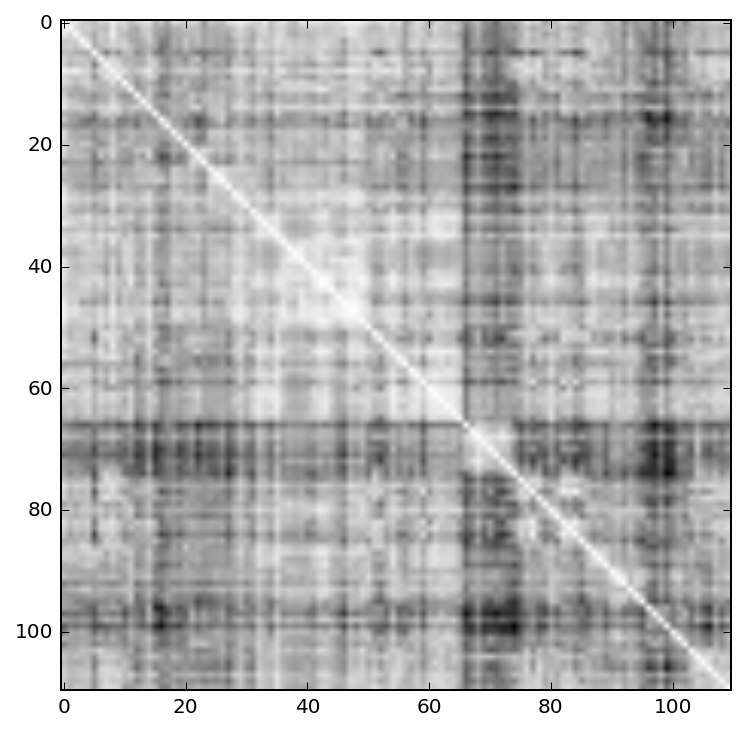

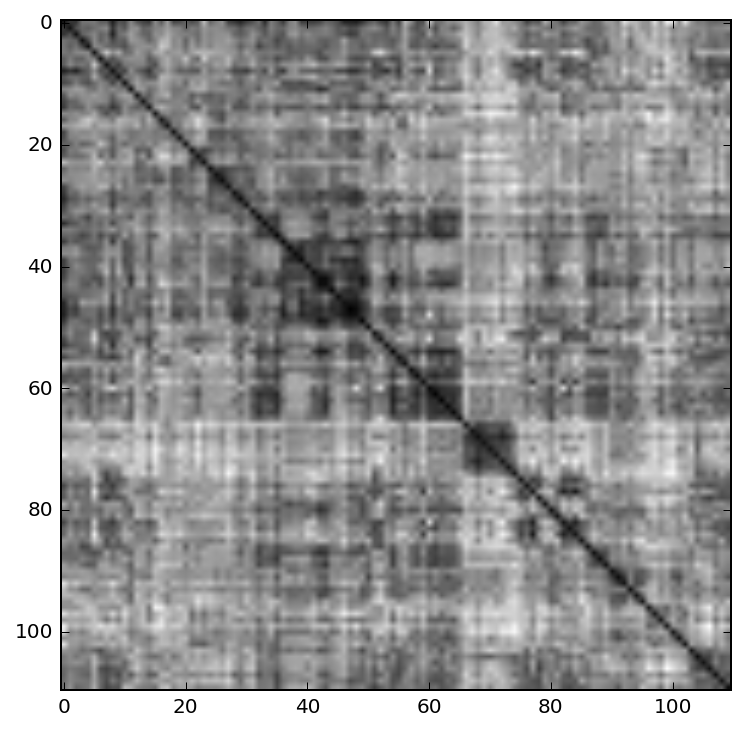

In [9]:
from scipy.linalg import fractional_matrix_power

Lij = np.zeros((N,N), np.float64)

for i in range(N):
    s1 = 0    
    for j in range(N):        
        s1 += Sij[i, j]
    Lij[i, i] = s1
Lij2 = fractional_matrix_power(Lij, -0.5)
Snorm = np.dot(np.dot(Lij2, Sij), Lij2).astype('float64')
#plot_array(Snorm)

plt.figure()
plt.imshow(Sij, cmap='gray')
plt.show()
plt.figure()
plt.imshow(Snorm, cmap='gray')
plt.show()

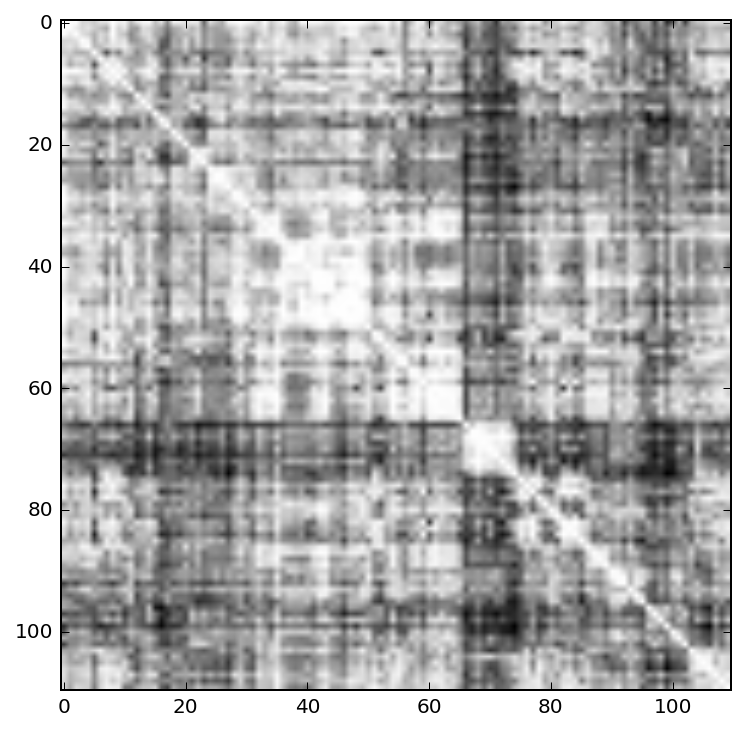

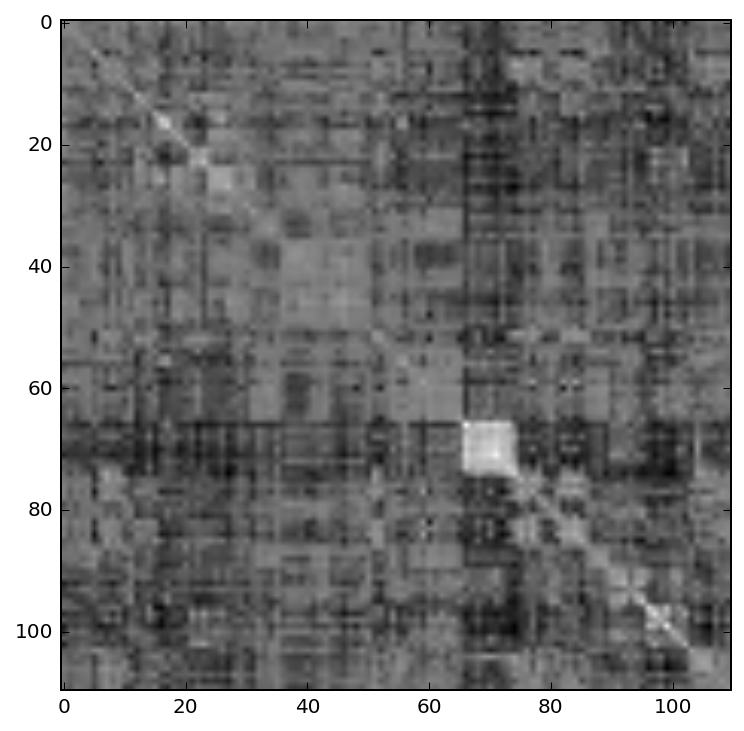

In [10]:
#Zelnik-Perona normalization, doesn't give us good results :(

Sij2 = np.zeros((N,N), np.float64)
        
sigmaK = np.zeros(Sij2.shape[0])
for i in range(Sij2.shape[0]):
    row = Sij[i, :]
    sigmaK[i] = np.sort(row)[6]
    #gm1 = GaussianMixture(n_components=1, covariance_type='diag')    
    #gm1.fit(row.reshape(-1, 1))
    #sigmaK[i] = gm1.covariances_[0][0]

for i in range(Sij2.shape[0]):
    for j in range(Sij2.shape[0]):
        Sij2[i,j] = np.exp((-1.0 * (Sij[i,j]**2.0)) / (sigmaK[i] * sigmaK[j]))
        
plt.figure()
plt.imshow(Sij2, cmap='gray')
plt.show()

D = np.diag(Sij2.sum(axis=1)**-0.5)
                
_L = np.dot(D,Sij2)
L = np.dot(_L,D)
Snorm = L

plt.figure()
plt.imshow(Snorm, cmap='gray')
plt.show()

Km= 20
(110, 20)
0.774059265974
0.999978622867
0.959929189026
0.64562897571
0.998919841325
0.991969455502
0.998074927184
0.999900066903
0.489041294506
0.166284297514
0.133641820392
0.740663064225
0.989338405056
0.30804234973
0.999948139942
0.0860716828909
0.1112973831
0.370432980169
0.999785395582
0.998154816521
New Km= 13
(110, 13)
1 11408.1963505 inf
2 11474.6299317 0.00578960555312
3 10959.7183232 0.0409205797172
4 11080.126885 0.0108670742727
5 10888.2351245 0.00656517772351
6 10539.4494931 0.0330933443525
7 10329.7799753 0.020297578292
8 10141.8848543 0.0185266470467
9 10075.6908098 0.00656967802133
10 9933.64451744 0.0142995143538
11 10051.5330984 0.0117284179281
12 10184.6880957 0.0246491179615
13 9391.00291024 0.0577831369431
13


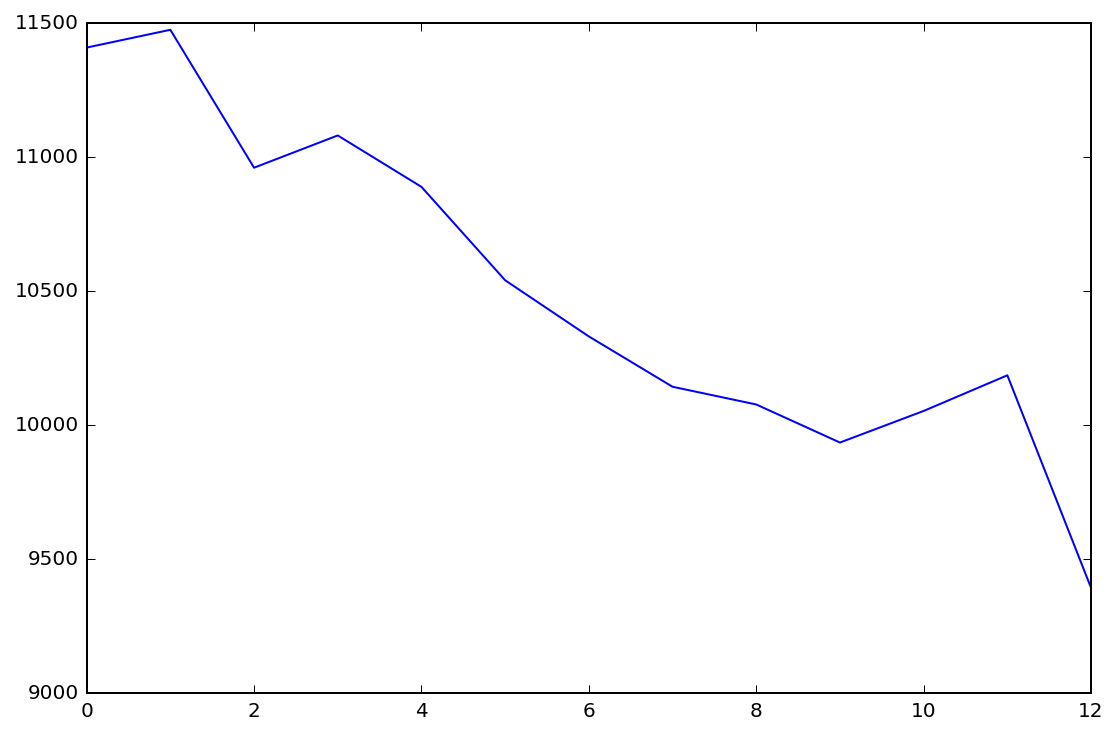

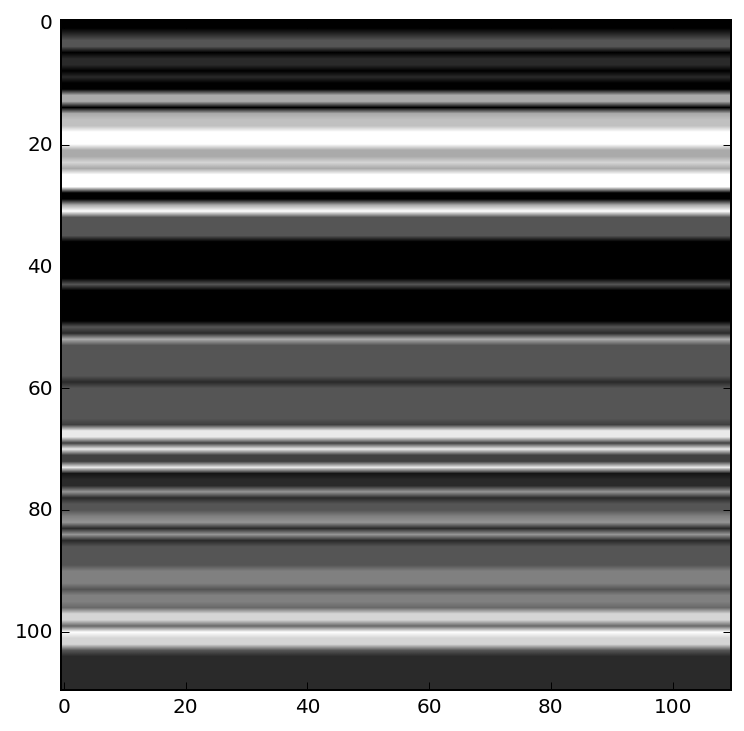

In [11]:
import mixem

Km = int(N / 5)
Km = np.min(np.array([Km, 20]))

Snorm_vals, Snorm_vecs = np.linalg.eigh(Sij)

Snorm_vecs = Snorm_vecs.T

for i in range(len(Snorm_vecs)):
    Snorm_vecs[i, :] *= Snorm_vals[i]
    #Snorm_vecs[i, :] *= 1000

indices = np.argsort(Snorm_vals)[::-1][:Km]
#indices = list(range(N-Km, N))[::-1]

top_vecs = Snorm_vecs[indices].T

assert(N == len(top_vecs))

print("Km=",Km)
print(top_vecs.shape)

def my_em(data, distributions, initial_weights=None, max_iterations=100, tol=1e-15, tol_iters=10, progress_callback=mixem.simple_progress):    
    n_distr = len(distributions)
    n_data = data.shape[0]

    if initial_weights is not None:
        weight = np.array(initial_weights)
    else:
        weight = np.ones((n_distr,))

    last_ll = np.zeros((tol_iters, ))
    resp = np.empty((n_data, n_distr))
    log_density = np.empty((n_data, n_distr))
    
    Rk = 0

    iteration = 0
    while True:
        # E-step #######

        # compute responsibilities
        for d in range(n_distr):
            log_density[:, d] = distributions[d].log_density(data)

        # normalize responsibilities of distributions so they sum up to one for example
        resp = weight[np.newaxis, :] * np.exp(log_density)
        resp /= np.sum(resp, axis=1)[:, np.newaxis]

        log_likelihood = np.sum(resp * log_density)

        # M-step #######
        h1 = resp[:, 0]
        h2 = resp[:, 1]
        h3 = resp[:, 2]
                                                
        for d in range(n_distr):            
            if d != 0:
                distributions[d].estimate_parameters(data, resp[:, d])
                distributions[d].sigma += 1e-6
                
        Rk = 1.0 - np.mean(h1)
        wk = np.mean(h2) / Rk
        
        weight[0] = 1.0 - Rk
        weight[1] = wk*Rk
        weight[2] = (1.0 - wk)*Rk
        
        assert(np.allclose(np.sum(weight), 1.0))

        if progress_callback:
            progress_callback(iteration, weight, distributions, log_likelihood)

        # Convergence check #######
        if np.isnan(log_likelihood):
            last_ll[0] = log_likelihood
            break

        if iteration >= tol_iters and np.abs(log_likelihood - last_ll[-1]) / np.abs(log_likelihood) <= tol:
            last_ll[0] = log_likelihood
            break

        if iteration >= max_iterations:
            last_ll[0] = log_likelihood
            break

        # store value of current iteration in last_ll[0]
        # and shift older values to the right
        last_ll[1:] = last_ll[:-1]
        last_ll[0] = log_likelihood

        iteration += 1

    return Rk, distributions, last_ll[0]

new_top_vecs = []
new_rks = []

for i in range(Km):
    mk1 = np.sum(top_vecs[:, i]) * (1.0 / N)
    sigma_k1 = np.sqrt(np.sum((top_vecs[:, i] - mk1) ** 2) * (1.0 / N))    
                            
    gm1 = GaussianMixture(n_components=1, covariance_type='diag', means_init=[[mk1]], precisions_init=[[1.0 / (sigma_k1 * sigma_k1)]])
    gm1.fit(top_vecs[:, i].reshape(-1, 1))
            
    dist0 = mixem.distribution.NormalDistribution(gm1.means_[0][0], np.sqrt(gm1.covariances_[0][0]))
                
    gm1 = GaussianMixture(n_components=2, covariance_type='diag')
    gm1.fit(top_vecs[:, i].reshape(-1, 1))
                    
    max_ds = [
        dist0,
        mixem.distribution.NormalDistribution(gm1.means_[0][0], np.sqrt(gm1.covariances_[0][0])),
        mixem.distribution.NormalDistribution(gm1.means_[1][0], np.sqrt(gm1.covariances_[1][0]))]
            
    max_ws = [0.5, gm1.weights_[0] * 0.5, gm1.weights_[1] * 0.5]
        
    Rk, ds, ll = my_em(top_vecs[:, i], max_ds,
        initial_weights = max_ws, progress_callback=None,
        tol_iters=100, max_iterations=10000, tol=1e-6)
        
    print(Rk)
    if (Rk >= 0.5):
        new_top_vecs.append(top_vecs[:, i])
        new_rks.append(Rk)
                
top_vecs = np.array(new_top_vecs)
new_rks = np.array(new_rks)

new_rks /= np.sum(new_rks)

for i in range(len(top_vecs)):
    top_vecs[i, :] *= new_rks[i]

Km = len(top_vecs)
print("New Km=",Km)
top_vecs = top_vecs.T
print(top_vecs.shape)

eig_gmm = classify1(top_vecs, Km, False)

finalK = eig_gmm.n_components

top_classes = eig_gmm.predict(top_vecs)

AM = np.zeros((N,N), np.float64)
for i in range(N):            
    for j in range(N):            
        AM[i, j] = top_classes[i]
            
plt.figure()
plt.imshow(AM, cmap='gray')
plt.show()

12


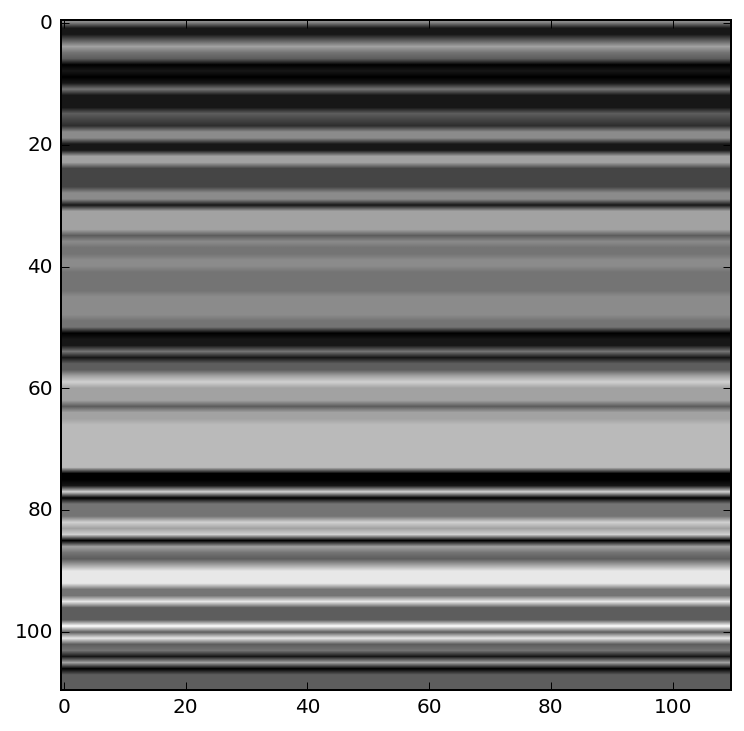

In [12]:
from sklearn.cluster import AffinityPropagation

af = AffinityPropagation(affinity='precomputed').fit(Sij)

finalK2 = len(af.cluster_centers_indices_)
print(finalK2)

AM = np.zeros((N,N), np.float64)
for i in range(N):            
    for j in range(N):            
        AM[i, j] = af.labels_[i]
            
plt.figure()
plt.imshow(AM, cmap='gray')
plt.show()

In [13]:
#finalK = 7
#eig_gmm = GaussianMixture(n_components=finalK, covariance_type='full', random_state=0)
#eig_gmm.fit(top_vecs)

final_hmms = []
final_nk = []
top_classes = eig_gmm.predict(top_vecs)
#top_classes = af.labels_
#finalK = finalK2
for i in range(finalK):    
    tmp1 = []
    num = 0
    tmp1_ls = []
    for j in range(N):
        if top_classes[j] == i:
            tmp1 += PN[j]
            tmp1_ls.append(len(PN[j]))
            num += 1
    hmm1 = hmm.GaussianHMM(n_components=bgmm.n_components, covariance_type="diag")
    hmm1.fit(tmp1, tmp1_ls)    
    final_hmms.append(hmm1)
    final_nk.append(num)    

/usr/local/lib/python3.5/dist-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/hmmlearn-0.2.1-py3.5-linux-x86_64.egg/hmmlearn/base.py:465: DeprecationWarning: `logsumexp` is deprecated!
Importing `logsumexp` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.logsumexp` instead.
  return logsumexp(fwdlattice[-1]), fwdlattice
/usr/local/lib/python3.5/dist-packages/hmmlearn-0.2.1-py3.5-linux-x86_64.egg/hmmlearn/utils.py:46: DeprecationWarning: `logsumexp` is deprecated!
Importing `logsumexp` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.logsumexp` instead.
  a_lse = logsumexp(a, axis)


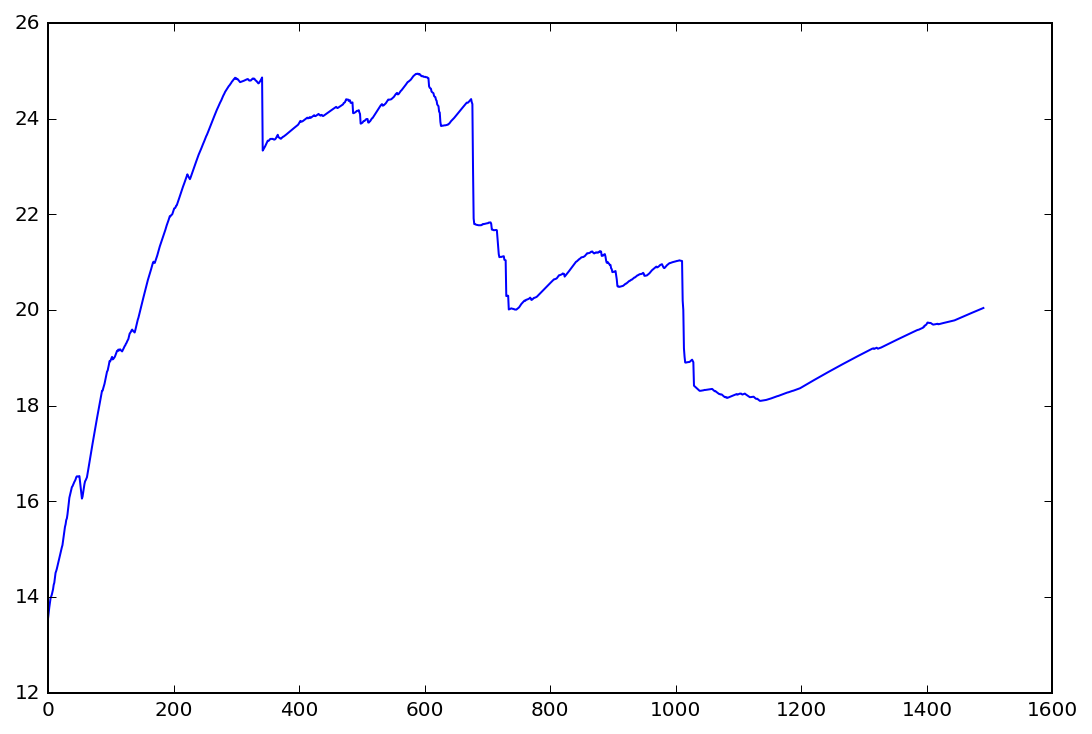

In [33]:
from hmmlearn.stats import _log_multivariate_normal_density_diag
from sklearn.utils import check_array
from sklearn.utils.validation import check_is_fitted
from hmmlearn.utils import log_mask_zero
from scipy.special import logsumexp

df_test = pd.read_csv("data_reception_test_short_1.csv")
df_test.drop([df_test.columns[0], "Rf"], inplace=True, axis=1)
#df_test = extend_set(df_test)
#df_test = extend_set(df_test)
#df_test = extend_set(df_test)

df2_test = df_test.drop([df_test.columns[0], df_test.columns[1]], axis=1)
df2_test = pd.DataFrame(scaler.transform(df2_test), columns=df_test.columns[2:])

df3_test = pd.DataFrame(bgmm.predict_proba(df2_test))
df3_test["time"] = df_test["time"]
df3_test["frame"] = df_test["frame"]
df3_test = df3_test.groupby(['time', 'frame']).agg('max')
df3_test.reset_index(inplace=True)

lattices = []

work_buffer = np.zeros(bgmm.n_components)

def my_forward_pass(hmm, fwdlattice, framelogprob, n_samples):
    n_samples_aa, n_components = framelogprob.shape    
    log_startprob = log_mask_zero(hmm.startprob_)
    log_transmat = log_mask_zero(hmm.transmat_)    
    if (n_samples == 1):
        for i in range(n_components):            
            fwdlattice[0, i] = log_startprob[i] + framelogprob[0, i]
    else:                    
        for j in range(n_components):
            for i in range(n_components):
                work_buffer[i] = fwdlattice[n_samples - 2, i] + log_transmat[i, j]            
            fwdlattice[n_samples - 1, j] = logsumexp(work_buffer) + framelogprob[0, j]
    return logsumexp(fwdlattice[n_samples - 1])

def calc_final_prob(samples):
    i_a = []
    i_b = []
    
    for i in range(finalK):                                
        lgg = _log_multivariate_normal_density_diag(check_array([samples[-1]]), final_hmms[i].means_, final_hmms[i]._covars_)        
        my_s = my_forward_pass(final_hmms[i], lattices[i], lgg, len(samples))
        act_s = my_s
        
        #act_s = final_hmms[i].score(samples)        
        #assert(np.allclose(my_s, act_s))
                        
        i_a.append(act_s)
        i_b.append(float(final_nk[i]) / float(N))        
        
    return scipy.special.logsumexp(a=i_a, b=i_b)

def calc_final_prob_i(samples, i):
    lgg = _log_multivariate_normal_density_diag(check_array([samples[-1]]), final_hmms[i].means_, final_hmms[i]._covars_)
    return my_forward_pass(final_hmms[i], lattices[i], lgg, len(samples))

TestPN = df3_test.drop(["time", "frame"], axis=1)
#TestPN = TestPN.head(1500)

for i in range(finalK):
    check_is_fitted(final_hmms[i], "startprob_")
    final_hmms[i]._check()
    lattices.append(np.zeros((len(TestPN), bgmm.n_components)))
                    
test_arr = []
scrs = []
scrs_raw = []
j = 1

for i in range(len(TestPN)):
    r = TestPN.iloc[i].ravel()
    test_arr.append(r)
    prb = calc_final_prob(test_arr)
    scrs.append(prb / j)    
    scrs_raw.append(prb)    
    j += 1
    
plt.figure()
plt.plot(scrs[int(seg_len * 1.5 * 10):])
#plt.plot(scrs)
plt.show()

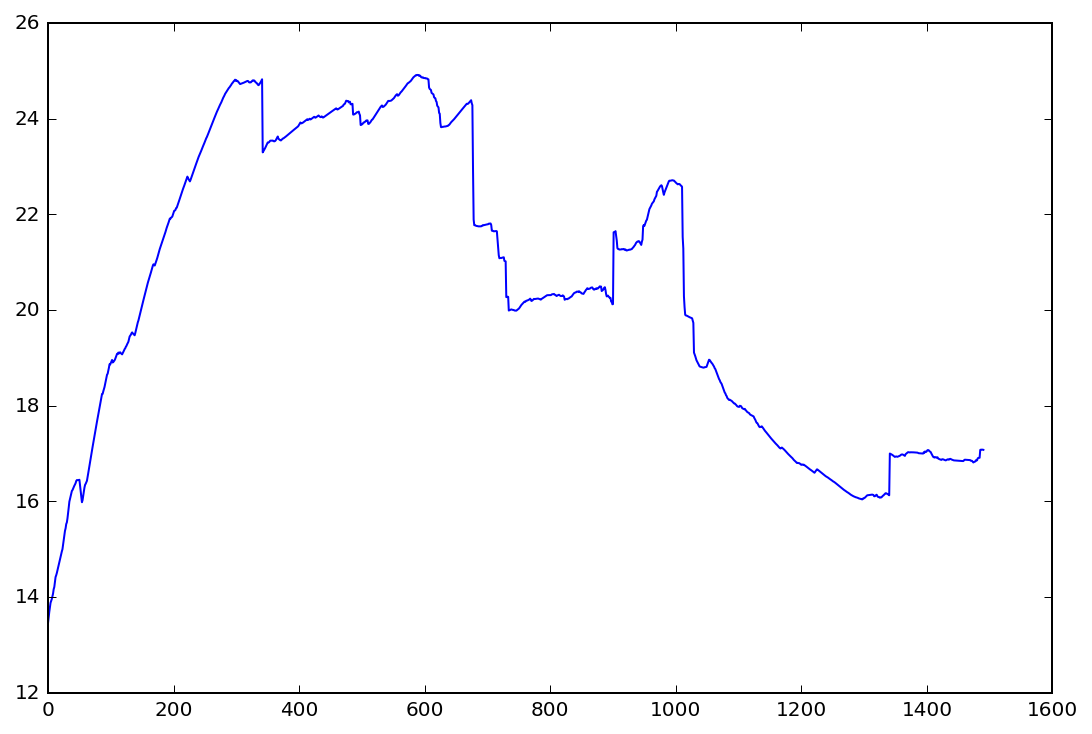

In [34]:
scrs3 = []

wnd = 1000

for i in range(len(TestPN)):    
    if i >= wnd:
        scrs3.append((scrs_raw[i] - scrs_raw[i - wnd + 1]) / float(wnd))
    elif i >= 1:
        scrs3.append((scrs_raw[i] - scrs_raw[0]) / (i + 1))
    else:
        scrs3.append(scrs_raw[0])
    
plt.figure()
#plt.plot(range(int(seg_len * 1.5 * 10), len(scrs3)), scrs3[int(seg_len * 1.5 * 10):])
#plt.plot(scrs3)
plt.plot(scrs3[int(seg_len * 1.5 * 10):])
plt.show()    

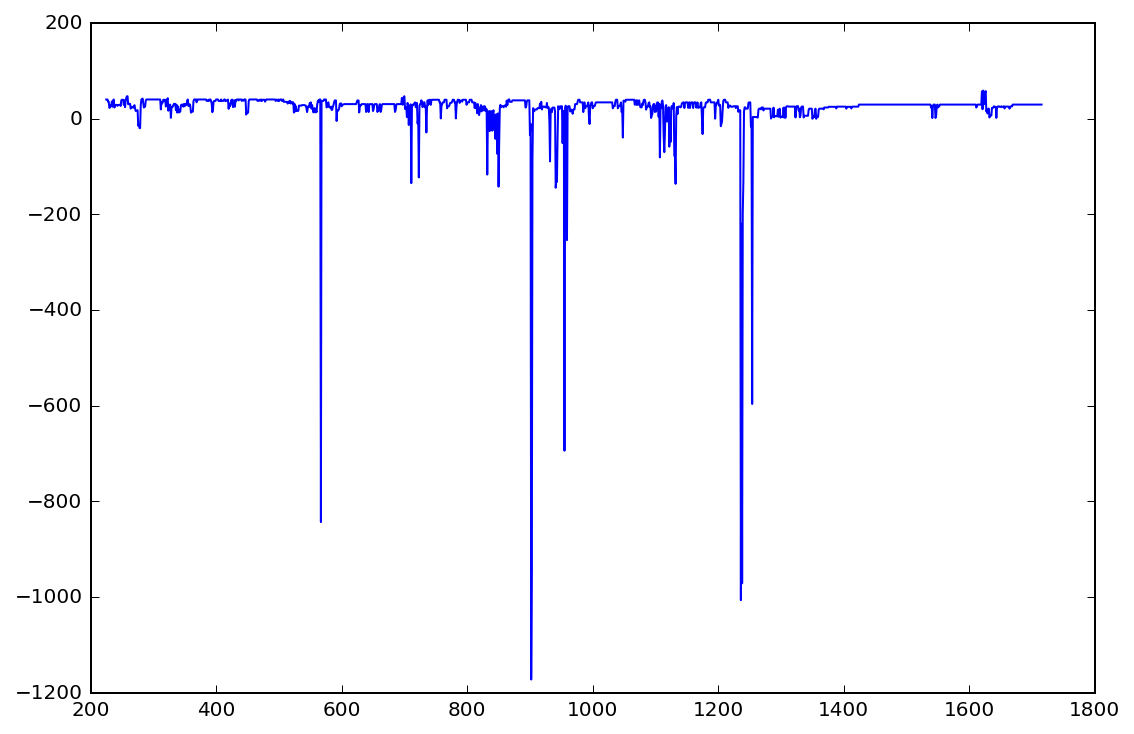

In [35]:
scrs2 = []

prev = 0

for i in range(len(TestPN)):    
    scrs2.append((scrs_raw[i] - prev) / (0 + 1))
    prev = scrs_raw[i]
    
plt.figure()
plt.plot(range(int(seg_len * 1.5 * 10), len(scrs2)), scrs2[int(seg_len * 1.5 * 10):])
plt.show()    

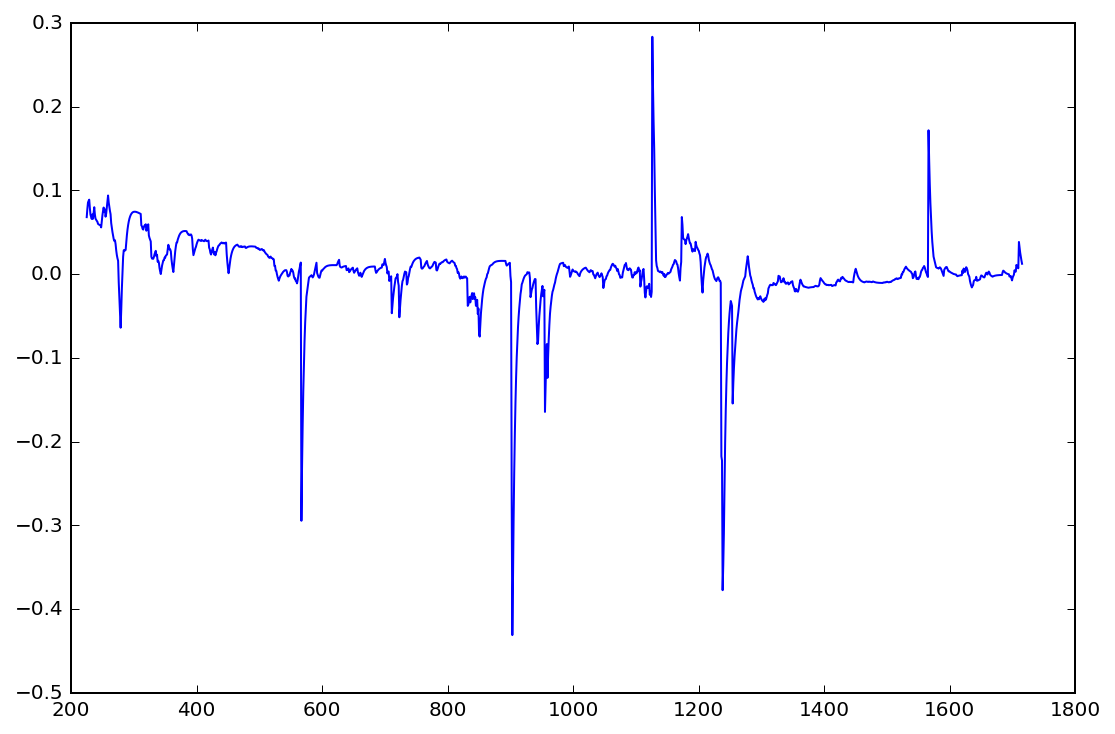

In [37]:
import traceback

Qt = 0
alpha = 0.2

first_frm = int(seg_len * 1.5 * 10)
#first_frm = 5000
first_frm_num = 0

qts = {}
qts_lst = []
frm_to_i = {}
for i in range(len(scrs)):
    if i == 0:
        Qt = scrs3[0]
    else:
        Qt = (1 - alpha) * Qt + alpha * (scrs3[i] - scrs3[i - 1])
        #Qt = (1 - alpha) * Qt + alpha * scrs2[i]
    #Qt = scrs2[i]    
    qts[df3_test.iloc[i]["frame"]] = Qt
    frm_to_i[df3_test.iloc[i]["frame"]] = i
    qts_lst.append(Qt)
    if i == first_frm:
        first_frm_num = df3_test.iloc[i]["frame"]
            
plt.figure()
plt.plot(range(first_frm, len(qts_lst)), qts_lst[first_frm:])
plt.show()

#cap = cv2.VideoCapture('Datasets/Pedestrian/test.avi')
#cap = cv2.VideoCapture('z3.avi')
#cap = cv2.VideoCapture('kitchen2.avi')
#cap = cv2.VideoCapture('Datasets/Crossroads1/test.avi')
cap = cv2.VideoCapture('reception_test_short_1.avi')
ok, frame = cap.read()
aspect = float(frame.shape[1]) / frame.shape[0]
cap.release()
#cap = cv2.VideoCapture('Datasets/Pedestrian/test.avi')
#cap = cv2.VideoCapture('z3.avi')
#cap = cv2.VideoCapture('kitchen2.avi')
#cap = cv2.VideoCapture('Datasets/Crossroads1/test.avi')
cap = cv2.VideoCapture('reception_test_short_1.avi')

try:
    while True:
        ok, frame = cap.read()
        if not ok:
            break
        frame = cv2.resize(frame, (int(240 * aspect), 240), interpolation = cv2.INTER_AREA)    
        fnum = cap.get(cv2.CAP_PROP_POS_FRAMES)    
        delay = 1
        if (fnum >= first_frm_num) and (fnum in qts):
            if qts[fnum] < -0.2:
                cv2.rectangle(frame, (0,0), (frame.shape[1], frame.shape[0]), (0,0,255), 10)
                delay = 0
                #print("frame", frm_to_i[fnum])
        cv2.imshow('frame', frame)        
        k = cv2.waitKey(delay) & 0xff        
        #if delay == 0:
        #    time.sleep(1)
        if k == 32:
            k = cv2.waitKey() & 0xff
        if k == 27:
            break
except Exception as e:    
    traceback.print_exc()

cap.release()
cv2.destroyAllWindows()